# Analisis de discriminante y k-vecinos - Rodríguez, Maximiliano

In [368]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets

In [369]:
data = sklearn.datasets.load_iris(as_frame=True);
df = data['data']

df = df.drop(columns=['petal length (cm)', 'petal width (cm)'])
df['species'] = data['target']
# 0: 'setosa', 1: 'versicolor', 2: 'virginica'
df

,sepal length (cm),sepal width (cm),species
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
...,...,...,...
145,6.7,3.0,2
146,6.3,2.5,2
147,6.5,3.0,2
148,6.2,3.4,2


Text(0, 0.5, 'Ancho del Sépalo (cm)')

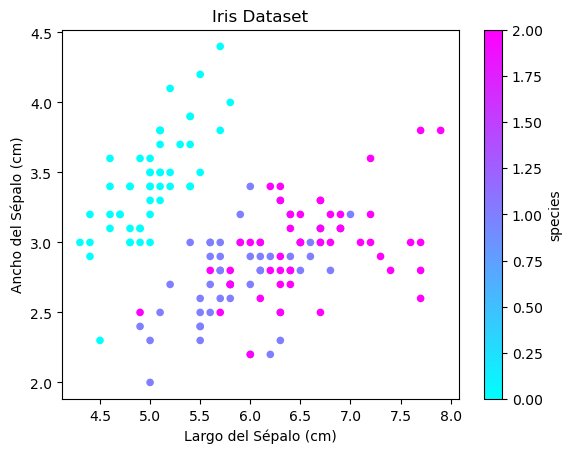

In [370]:
scatter = df.plot.scatter(x='sepal length (cm)', y='sepal width (cm)', c='species', colormap='cool')
plt.title('Iris Dataset')
plt.xlabel('Largo del Sépalo (cm)')
plt.ylabel('Ancho del Sépalo (cm)')

In [371]:
X_np = df[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
y_np = df['species'].to_numpy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, train_size = 0.7, test_size=0.3, random_state=0)


print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (105, 2)
X_test shape: (45, 2)
y_train shape: (105,)
y_test shape: (45,)


In [372]:
from scipy.special import softmax

class LDA:
    def __init__(self):
        self.clases = None
        self.mu_k = {}
        self.c_k = {}
        self.sigma = None
        self.sigma_inv = None
        self.w = {}
        self.b = {}


    def fit(self, X, y):
        self.clases = np.unique(y)
        n_clases = len(self.clases)
        n_muestras = X.shape[0]

        self.D_k = {}
        self.c_k = {}
        self.mu_k = {}
        self.sigma_k = {}
        total_sigma = np.zeros((X.shape[1], X.shape[1]))  # para acumular Σ

        for k in self.clases:
            D_k = X[y == k]
            self.D_k[k] = D_k
            self.c_k[k] = len(D_k) / n_muestras
            self.mu_k[k] = np.mean(D_k, axis=0)
            self.sigma_k[k] = np.cov(D_k.T, bias=False)  # dividimos por |Dk| - 1

            # Acumular para el cálculo de Σ (la covarianza global)
            total_sigma += (len(D_k) - 1) * self.sigma_k[k]

        self.sigma = total_sigma / (n_muestras - n_clases)
        self.sigma_inv = np.linalg.inv(self.sigma)

        # Cálculo de w_y y b_y para cada clase
        self.w = {}
        self.b = {}
        for k in self.clases:
            mu = self.mu_k[k]
            c = self.c_k[k]
            self.w[k] = self.sigma_inv @ mu
            self.b[k] = -0.5 * mu.T @ self.sigma_inv @ mu + np.log(c)

        return self

    def predict_proba(self, X):
        recta = np.array([X @ self.w[k] + self.b[k] for k in self.clases])  # (k, n_muestras)
        probs = softmax(recta, axis=0).T  # (n_muestras, k)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        return self.clases[np.argmax(probs, axis=1)]


In [373]:
LDA = LDA()
LDA.fit(X_train, y_train)
y_pred = LDA.predict(X_test)

# Imprimir resultados para verificar
print("Predicciones:", y_pred)
print("Precisión:", np.mean(y_pred == y_test))


Predicciones: [1 1 0 2 0 2 0 2 2 1 1 2 1 2 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 2 1 0 1 2 1 0
 1 1 1 2 0 2 0 0]
Precisión: 0.8


In [374]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import multivariate_normal

# def obtener_color(n, colormap='cool'):
#     cmap = plt.colormaps[colormap]
#     return [cmap(i / (n - 1)) for i in range(n)]

# def plot_lda_contours_with_df(model, X, y, df):
#     clases = model.clases
#     colores = obtener_color(len(clases), 'cool')

#     fig, ax = plt.subplots()

#     # Hacer el scatter con pandas, pero en el mismo ax
#     df.plot.scatter(x='sepal length (cm)', y='sepal width (cm)', c='species', colormap='cool', ax=ax, alpha=0.5)

#     # Crear grilla para curvas de nivel
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
#                          np.linspace(y_min, y_max, 200))
#     grid = np.c_[xx.ravel(), yy.ravel()]

#     for idx, k in enumerate(clases):
#         color = colores[idx % len(colores)]

#         # Media
#         mu = model.mu_k[k]
#         ax.plot(mu[0], mu[1], 'x', color=color, markersize=10, mew=2)

#         # Curvas de nivel
#         dist = multivariate_normal(mean=mu, cov=model.sigma)
#         z = dist.pdf(grid).reshape(xx.shape)
#         ax.contour(xx, yy, z, levels=3, colors=[color], linestyles='--')

#     ax.set_title("LDA: medias y curvas de nivel + scatter")
#     ax.axis('equal')
#     ax.grid(True)
#     plt.show()
# plot_lda_contours_with_df(LDA, X_train, y_train, df)

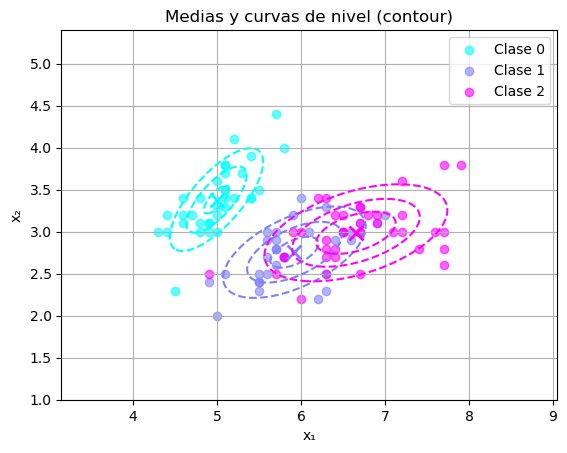

In [375]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal


def plot_lda_contours(model, X, y):
    clases = model.clases
    colores = obtener_color(len(clases), 'cool')
    fig, ax = plt.subplots()

    # Crear grilla para curvas de nivel
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]

    for idx, k in enumerate(clases):
        color = colores[idx]

        # Scatter de puntos de esa clase
        X_k = X[y == k]
        ax.scatter(X_k[:, 0], X_k[:, 1], alpha=0.6, color=color, label=f"Clase {k}")

        # Media de la clase
        mu = model.mu_k[k]
        ax.plot(mu[0], mu[1], 'x', color=color, markersize=10, mew=2)

        # Evaluar densidad gaussiana
        if hasattr(model, 'sigma_k'):
            cov = model.sigma_k[k]  # QDA
        else:
            cov = model.sigma       # LDA

        dist = multivariate_normal(mean=mu, cov=cov)
        z = dist.pdf(grid).reshape(xx.shape)

        # Curvas de nivel
        ax.contour(xx, yy, z, levels=3, colors=[color], linestyles='--')

    ax.set_title("Medias y curvas de nivel (contour)")
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")
    ax.axis('equal')
    ax.legend()
    ax.grid(True)
    plt.show()
plot_lda_contours(LDA, X_train, y_train)


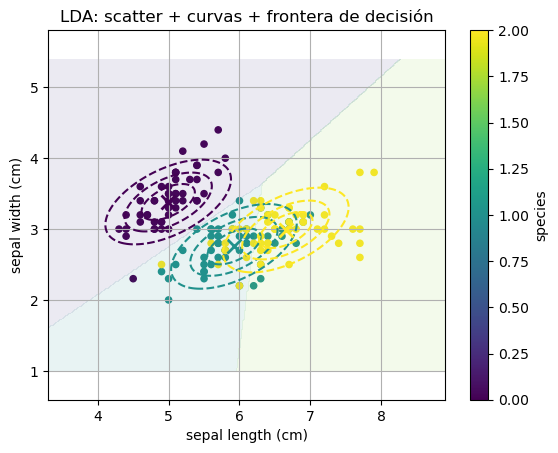

In [376]:
def plot_lda_full(model, X, y, df, feature_x, feature_y):
    clases = model.clases
    colores = get_viridis_colors(len(clases))

    fig, ax = plt.subplots()

    # Scatter con pandas en el mismo ax
    df.plot.scatter(x=feature_x, y=feature_y, c='species', colormap='viridis', ax=ax)

    # Crear grilla para curvas de nivel y fronteras
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predecir clases para cada punto de la grilla
    y_pred = model.predict(grid)
    Z = y_pred.reshape(xx.shape)

    # Dibujar fronteras de decisión (con colores suaves)
    ax.contourf(xx, yy, Z, levels=len(clases)-1, alpha=0.1, cmap='viridis')

    # Curvas de nivel de cada clase
    for idx, k in enumerate(clases):
        mu = model.mu_k[k]
        ax.plot(mu[0], mu[1], 'x', color=colores[idx], markersize=10, mew=2)

        dist = multivariate_normal(mean=mu, cov=model.sigma)
        z = dist.pdf(grid).reshape(xx.shape)
        ax.contour(xx, yy, z, levels=3, colors=[colores[idx]], linestyles='--')

    ax.set_title("LDA: scatter + curvas + frontera de decisión")
    ax.axis('equal')
    ax.grid(True)
    plt.show()
plot_lda_full(LDA, X_train, y_train, df, 'sepal length (cm)', 'sepal width (cm)')

In [377]:
def generar_muestras_sinteticas(model, n=30, random_state=None):
    np.random.seed(random_state)
    
    clases = list(model.clases)
    probabilidades = [model.c_k[k] for k in clases]

    # Elegimos clases según las probabilidades c_k
    clases_sinteticas = np.random.choice(clases, size=n, p=probabilidades)

    # Generamos las muestras
    X_sintetico = np.array([
        np.random.multivariate_normal(mean=model.mu_k[k], cov=model.sigma)
        for k in clases_sinteticas
    ])

    return X_sintetico, clases_sinteticas


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


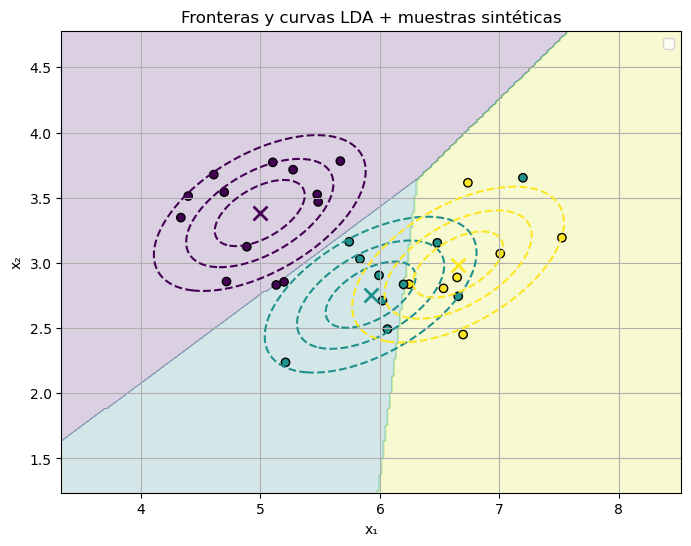

In [378]:
# Generamos las muestras
X_sintetico, y_sintetico = generar_muestras_sinteticas(model=LDA, n=30, random_state=42)

def plot_lda_solo_sinteticos(model, X_sintetico, y_sintetico):
    from matplotlib.colors import ListedColormap
    from scipy.stats import multivariate_normal

    clases = model.clases
    cmap = plt.cm.viridis
    colores = cmap(np.linspace(0, 1, len(clases)))

    fig, ax = plt.subplots(figsize=(8, 6))

    # Grilla para frontera de decisión
    x_min, x_max = X_sintetico[:, 0].min() - 1, X_sintetico[:, 0].max() + 1
    y_min, y_max = X_sintetico[:, 1].min() - 1, X_sintetico[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Frontera de decisión
    pred = model.predict(grid)
    Z = pred.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap)

    # Curvas de nivel de cada clase
    for idx, k in enumerate(clases):
        mu = model.mu_k[k]
        ax.plot(mu[0], mu[1], 'x', color=colores[idx], markersize=10, mew=2)

        dist = multivariate_normal(mean=mu, cov=model.sigma)
        z = dist.pdf(grid).reshape(xx.shape)
        ax.contour(xx, yy, z, levels=3, colors=[colores[idx]], linestyles='--')

    # Datos sintéticos
    ax.scatter(X_sintetico[:, 0], X_sintetico[:, 1], c=y_sintetico, cmap=cmap,
               marker='o', edgecolors='black')

    ax.set_title("Fronteras y curvas LDA + muestras sintéticas")
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")
    ax.legend()
    ax.grid(True)
    plt.show()
plot_lda_solo_sinteticos(LDA, X_sintetico, y_sintetico)

In [379]:
class Discriminante:
    def __init__(self, mode='lda'):
        assert mode in ['lda', 'qda'], "El modo debe ser 'lda' o 'qda'"
        self.mode = mode
        self.clases = None
        self.mu_k = {}
        self.c_k = {}
        self.sigma = None
        self.sigma_inv = None
        self.sigma_k = {}

    def fit(self, X, y):
        self.clases = np.unique(y)
        n_muestras = X.shape[0]
        n_clases = len(self.clases)

        self.mu_k = {}
        self.c_k = {}
        self.sigma_k = {}
        total_sigma = np.zeros((X.shape[1], X.shape[1]))

        for k in self.clases:
            X_k = X[y == k]
            self.c_k[k] = len(X_k) / n_muestras
            self.mu_k[k] = np.mean(X_k, axis=0)
            self.sigma_k[k] = np.cov(X_k.T, bias=False)
            if self.mode == 'lda':
                total_sigma += (len(X_k) - 1) * self.sigma_k[k]

        if self.mode == 'lda':
            self.sigma = total_sigma / (n_muestras - n_clases)
            self.sigma_inv = np.linalg.inv(self.sigma)

        return self

    def predict_proba(self, X):
        scores = []
        for k in self.clases:
            mu = self.mu_k[k]
            c = self.c_k[k]

            if self.mode == 'lda':
                w = self.sigma_inv @ mu
                b = -0.5 * mu.T @ self.sigma_inv @ mu + np.log(c)
                score = X @ w + b
            else:  # QDA
                sigma_k_inv = np.linalg.inv(self.sigma_k[k])
                diff = X - mu
                quad_term = np.sum(diff @ sigma_k_inv * diff, axis=1)
                det_sigma_k = np.linalg.det(self.sigma_k[k])
                log_det = np.log(det_sigma_k) if det_sigma_k > 0 else 0  # evitar log(0)
                score = -0.5 * quad_term - 0.5 * log_det + np.log(c)

            scores.append(score)

        scores = np.vstack(scores).T  # shape (n_muestras, n_clases)
        probs = softmax(scores, axis=1)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        return self.clases[np.argmax(probs, axis=1)]

In [380]:
QDA = Discriminante(mode='qda')
QDA.fit(X_train, y_train)
y_pred_qda = QDA.predict(X_test)
print("Predicciones QDA:", y_pred_qda)
print("Precisión QDA:", np.mean(y_pred_qda == y_test))

Predicciones QDA: [1 1 0 2 0 2 0 2 2 1 1 2 1 2 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 2 1 0 1 2 1 0
 1 1 1 2 0 2 0 0]
Precisión QDA: 0.8


In [381]:
def generar_muestras_sinteticas(model, n=30, random_state=None):
    np.random.seed(random_state)
    X_sintetico = []
    y_sintetico = []

    for k in model.clases:
        mu = model.mu_k[k]
        if model.mode == 'lda':
            cov = model.sigma
        else:  # QDA
            cov = model.sigma_k[k]
        
        muestras_k = np.random.multivariate_normal(mu, cov, size=n)
        X_sintetico.append(muestras_k)
        y_sintetico.append(np.full(n, k))

    X_sintetico = np.vstack(X_sintetico)
    y_sintetico = np.concatenate(y_sintetico)

    return X_sintetico, y_sintetico

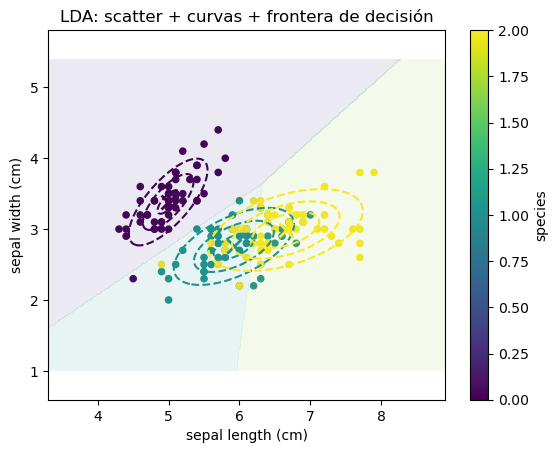

In [382]:
def plot_lda_full(model, X, y, df, feature_x, feature_y):
    clases = model.clases
    colores = get_viridis_colors(len(clases))

    fig, ax = plt.subplots()

    # Scatter con pandas en el mismo ax
    df.plot.scatter(x=feature_x, y=feature_y, c='species', colormap='viridis', ax=ax)

    # Crear grilla para curvas de nivel y fronteras
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predecir clases para cada punto de la grilla
    y_pred = model.predict(grid)
    Z = y_pred.reshape(xx.shape)

    # Dibujar fronteras de decisión (con colores suaves)
    ax.contourf(xx, yy, Z, levels=len(clases)-1, alpha=0.1, cmap='viridis')

    # Curvas de nivel de cada clase
    for idx, k in enumerate(clases):
        mu = model.mu_k[k]
        ax.plot(mu[0], mu[1], 'x', color=colores[idx], markersize=10, mew=2)

        # Adaptar covarianza según el tipo de modelo
        sigma = model.sigma_k[k] if hasattr(model, 'sigma_k') else model.sigma
        dist = multivariate_normal(mean=mu, cov=sigma)
        z = dist.pdf(grid).reshape(xx.shape)
        ax.contour(xx, yy, z, levels=3, colors=[colores[idx]], linestyles='--')
        
    ax.set_title("LDA: scatter + curvas + frontera de decisión")
    ax.axis('equal')
    plt.show()
plot_lda_full(LDA, X_train, y_train, df, 'sepal length (cm)', 'sepal width (cm)')

In [383]:
def plot_solo_sinteticos(model, X_sintetico, y_sintetico):
    clases = model.clases
    colores = get_viridis_colors(len(clases))

    fig, ax = plt.subplots()

    # Crear grilla para curvas de nivel y frontera
    x_min, x_max = X_sintetico[:, 0].min() - 1, X_sintetico[:, 0].max() + 1
    y_min, y_max = X_sintetico[:, 1].min() - 1, X_sintetico[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predecir clases para cada punto de la grilla
    y_pred = model.predict(grid)
    Z = y_pred.reshape(xx.shape)

    # Dibujar fronteras de decisión
    ax.contourf(xx, yy, Z, levels=len(clases)-1, alpha=0.1, cmap='viridis')

    # Dibujar curvas de nivel por clase
    for idx, k in enumerate(clases):
        mu = model.mu_k[k]
        sigma = model.sigma_k[k] if hasattr(model, 'sigma_k') else model.sigma

        ax.plot(mu[0], mu[1], 'x', color=colores[idx], markersize=10, mew=2)

        dist = multivariate_normal(mean=mu, cov=sigma)
        z = dist.pdf(grid).reshape(xx.shape)
        ax.contour(xx, yy, z, levels=3, colors=[colores[idx]], linestyles='--')

    # Graficar las muestras sintéticas
    ax.scatter(X_sintetico[:, 0], X_sintetico[:, 1], c=y_sintetico,
               cmap='viridis', marker='o', edgecolors='k')

    ax.set_title("Fronteras + curvas + muestras sintéticas")
    ax.axis('equal')
    plt.show()

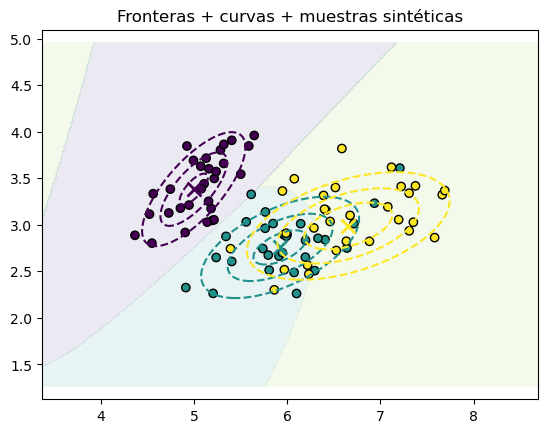

In [384]:
# Generar muestras sintéticas para QDA  
X_sintetico_qda, y_sintetico_qda = generar_muestras_sinteticas(model=QDA, n=30, random_state=42)
plot_solo_sinteticos(QDA, X_sintetico_qda, y_sintetico_qda)




In [385]:
from collections import Counter

class KNNClassifier:
    def __init__(self, k):
        self.k = k
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X_test):
        return np.array([self._predict_one(x) for x in X_test])
    
    def _predict_one(self, x):
        # Paso 1: Calcular distancias euclideanas a todos los puntos del entrenamiento
        distances = np.linalg.norm(self.X_train - x, axis=1)
        
        # Paso 2: Obtener los índices de los k vecinos más cercanos
        k_indices = distances.argsort()[:self.k]
        
        # Paso 3: Obtener las etiquetas de esos vecinos
        k_nearest_labels = self.y_train[k_indices]
        
        # Paso 4: Devolver la clase más común
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

In [386]:
KNN = KNNClassifier(k=6)
KNN.fit(X_train, y_train)
y_pred_knn = KNN.predict(X_test)
print("Predicciones KNN:", y_pred_knn)
print("Precisión KNN:", np.mean(y_pred_knn == y_test))



Predicciones KNN: [1 2 0 2 0 2 0 2 1 2 2 2 2 2 2 0 2 1 0 0 1 1 0 0 2 0 0 2 1 0 2 1 0 2 2 1 0
 2 1 1 2 0 1 0 0]
Precisión KNN: 0.7111111111111111


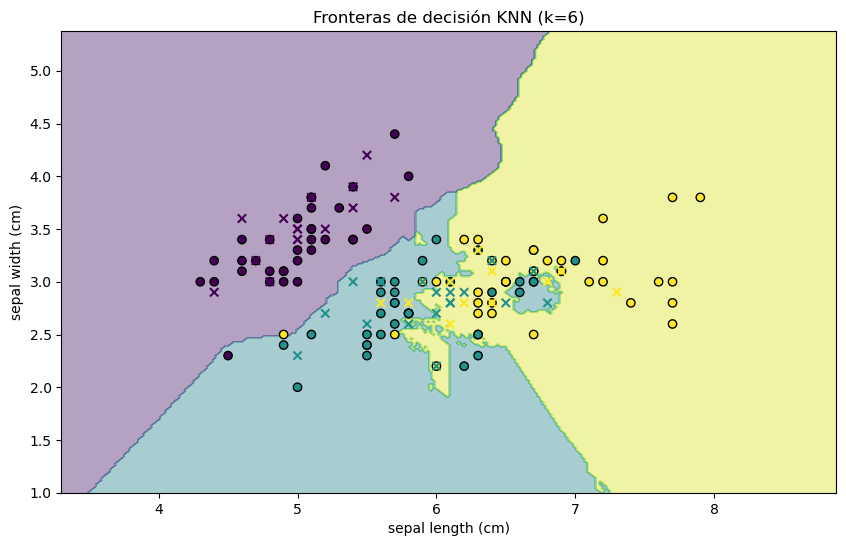

In [387]:
def plot_knn_decision_boundary(knn_model, X_train, y_train, X_test=None, y_test=None, feature_names=None, h=0.02):
    """
    Grafica las fronteras de decisión para un modelo KNN en 2D.

    Parámetros:
        - knn_model: instancia de tu clase KNNClassifier (ya entrenada).
        - X_train, y_train: datos de entrenamiento (con 2 features).
        - X_test, y_test: datos de test (opcional).
        - feature_names: lista con nombres de las features [nombre_x, nombre_y] (opcional).
        - h: resolución de la grilla (más chico = más fino = más lento).
    """
    # Chequeo que solo haya 2 features
    if X_train.shape[1] != 2:
        raise ValueError("Solo se puede graficar con 2 características (columnas).")

    # Definir rango del gráfico
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predecir sobre la grilla
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = knn_model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.viridis)

    # Entrenamiento
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.viridis,
                edgecolor='k', label='Train')

    # Test (opcional)
    if X_test is not None and y_test is not None:
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.viridis,
                    marker='x', label='Test')

    # Ejes
    if feature_names and len(feature_names) == 2:
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])
    else:
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")

    plt.title(f"Fronteras de decisión KNN (k={knn_model.k})")

    plt.show()
plot_knn_decision_boundary(KNN, X_train, y_train, X_test, y_test, feature_names=['sepal length (cm)', 'sepal width (cm)'])